<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps involved in the Kmeans Clustering are:
1. Read and visualise the data
2. Clean the data
3. Prepare the data for Modelling
4. Modelling
5. Final Analysis and Business recommendations

## Reading the Data

The data was downloaded from https://cdn.upgrad.com/UpGrad/temp/929fe498-1032-4ad6-997e-e3c8c33853ea/Online+Retail.csv

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import openai
from sklearn.metrics import silhouette_score


from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [6]:
df=pd.read_csv("Online+Retail.csv", sep=",",encoding='ISO-8859-1', header=0)

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
df.shape

(541909, 8)

## Clean the data

In [10]:
# Missind data
df.isnull().sum()/len(df)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [11]:
# Drop all rows having missing vslues
df=df.dropna()

In [12]:
df.shape

(406829, 8)

## Prepare the data for modelling

In [13]:
# R - Recency : No of Days since Last Purchase
# F - Frequency: No of Transactions
# M - Monetory value: Total revenue contributed

In [14]:
# Columns to create
# Cust_id Recency Frequency Monetory

In [15]:
# Monetory value column creation
# New Column Amount
df["Amount"]=df['Quantity']*df['UnitPrice']
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [16]:
#Monetory column: Groupby Customer Id and sum the amount
monetory = df.groupby(['CustomerID'])['Amount'].sum()
monetory=monetory.reset_index()

In [17]:
monetory

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [18]:
# Frequency

In [19]:
freq = df.groupby(['CustomerID'])['InvoiceNo'].count()
freq=freq.reset_index()
freq.columns = ['CustomerID','Frequency']
freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
rfm= pd.merge(monetory,freq,on='CustomerID',how='inner')

In [21]:
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [22]:
# Recency: NO of days since last invoice
# Select the max days and then compute the days from this date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [23]:
# Invoice date is of object type, we need to convert to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [25]:
#  Compute the max date. 
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [26]:
# Compute the difference
df['diff'] = max_date-df['InvoiceDate']

In [27]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [28]:
# Recency Column
recency = df.groupby('CustomerID')['diff'].min()
recency=recency.reset_index()

In [29]:
recency.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [30]:
rfm= pd.merge(rfm,recency,on='CustomerID',how='inner')

In [31]:
rfm.columns = ['CustomerID', 'Monetory','Frequency','Recency']
rfm.head()

,CustomerID,Monetory,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [32]:
#  We don't want the recency till the hours and minuutes. Just days will suffice
rfm['Recency']=rfm['Recency'].dt.days

In [33]:
rfm.head()

,CustomerID,Monetory,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [34]:
# Other Data Preparation steps required for Clustering are:
# 1.OUtlier Treatment
# 2.Rescaling: As the distance is based on the squares, it means amount distance will overpower th other metrics due to its large number.


<Axes: >

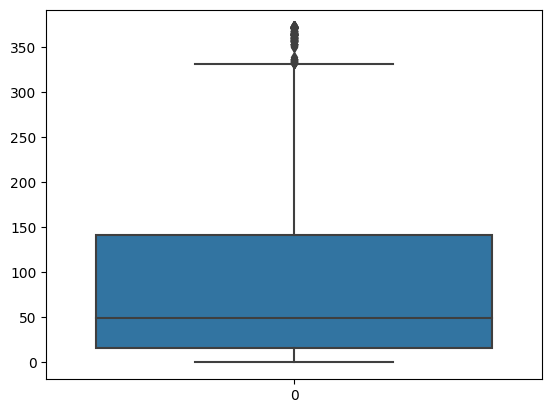

In [35]:
# Outlier Treatment
sns.boxplot(rfm['Recency'])

In [36]:
# There are 2 types of Outliers
# 1. Statistical Outlier
# 2. Domain Specific Outlier

In [37]:
# Removing Outliers Monetory
Q1 = rfm.Monetory.quantile(0.05)
Q3 = rfm.Monetory.quantile(0.95)
IQR = Q3-Q1
rfm=rfm[(rfm.Monetory >=Q1 - 1.5*IQR) & (rfm.Monetory <= Q3 +1.5*IQR)]

In [38]:
# Removing Outliers Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3-Q1
rfm=rfm[(rfm.Recency >=Q1 - 1.5*IQR) & (rfm.Recency <= Q3 +1.5*IQR)]

In [39]:
# Removing Outliers Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3-Q1
rfm=rfm[(rfm.Frequency >=Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 +1.5*IQR)]


In [40]:
# 2. Rescaling
new_rfm = rfm[['Monetory','Frequency','Recency']]

In [41]:
# instanciate the scaler
scaler= StandardScaler()

In [42]:
rfm_scaled = scaler.fit_transform(new_rfm)

In [43]:
rfm_scaled.shape

(4293, 3)

### 4.Modelling

In [44]:
# Making the Clusters
rfmdf_scaled = pd.DataFrame(rfm_scaled)

In [45]:
rfmdf_scaled.columns = ['Monetory','Frequency','Recency']
rfmdf_scaled.head()

,Monetory,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [46]:
# kmeans with arbitrart K
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfmdf_scaled)

KMeans(max_iter=50, n_clusters=4)

In [47]:
len(kmeans.labels_)

4293

### Finding the Optimal Number of Clusters

In [48]:
# elbow-curve / SSD
ssd=[]
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=5|0)
    kmeans.fit(rfmdf_scaled)
    
    ssd.append(kmeans.inertia_)

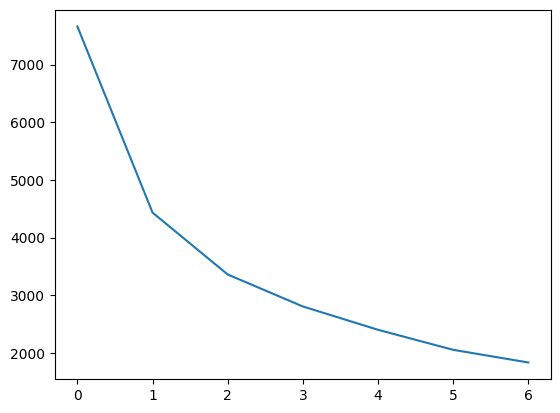

In [49]:
# plot the ssd for n_clusters
plt.plot(ssd)

In [50]:
ssd

[7662.254573753026,
 4434.353483235607,
 3361.0266106175723,
 2806.3969174731196,
 2401.7845390870352,
 2054.3364832976654,
 1834.8079545723078]

## Sihouette Analysis

In [51]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfmdf_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfmdf_scaled, cluster_labels)
    print("For n_clusters={0}, The silhouette Score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, The silhouette Score is 0.5415858652525395
For n_clusters=3, The silhouette Score is 0.5084896296141937
For n_clusters=4, The silhouette Score is 0.4812247940142438
For n_clusters=5, The silhouette Score is 0.46627005641897035
For n_clusters=6, The silhouette Score is 0.41698547252648926
For n_clusters=7, The silhouette Score is 0.4158653100759283
For n_clusters=8, The silhouette Score is 0.41252746777565014


In [52]:
# Cluster Analysis
kmeans = KMeans(n_clusters = 3, max_iter = 50)
kmeans.fit(rfmdf_scaled)
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [53]:
rfm['Cluster ID']=kmeans.labels_

In [54]:
rfm.head()

,CustomerID,Monetory,Frequency,Recency,Cluster ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<Axes: xlabel='Cluster ID', ylabel='Monetory'>

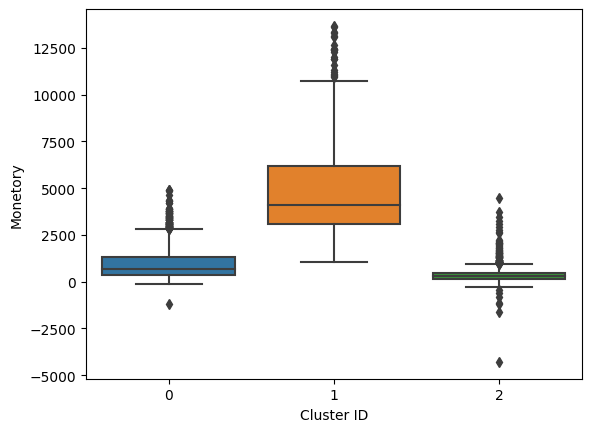

In [55]:
# Plot
sns.boxplot(x='Cluster ID', y='Monetory', data = rfm)

<Axes: xlabel='Cluster ID', ylabel='Recency'>

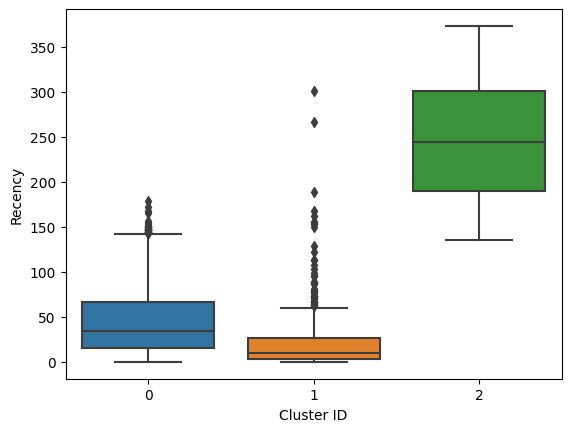

In [56]:
sns.boxplot(x='Cluster ID', y='Recency', data = rfm)

<Axes: xlabel='Cluster ID', ylabel='Frequency'>

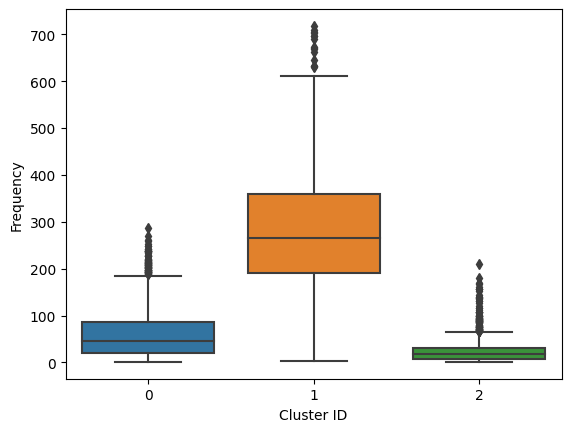

In [57]:
sns.boxplot(x='Cluster ID', y='Frequency', data = rfm)

# Hierarchy Cluster


In [58]:
rfm.head()

,CustomerID,Monetory,Frequency,Recency,Cluster ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


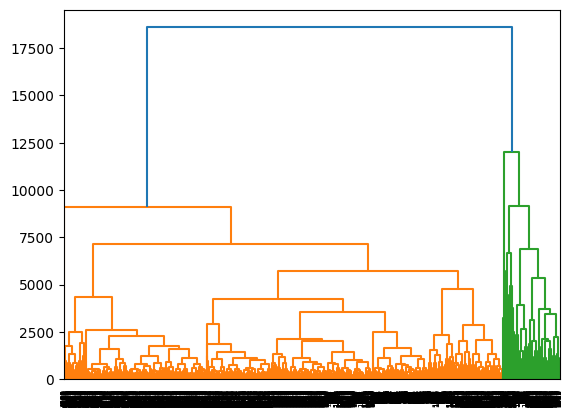

In [68]:
# Single Linkage
merging = linkage(rfm, method="complete", metric='euclidean')
dendrogram(merging)
plt.show()

In [72]:
cluster_labels = cut_tree(merging, n_clusters=3).reshape(-1,)
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [73]:
rfm["Hierarchy Clusters"] = cluster_labels

In [74]:
rfm.head()

,CustomerID,Monetory,Frequency,Recency,Cluster ID,Hierarchy Clusters
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


<Axes: xlabel='Hierarchy Clusters', ylabel='Monetory'>

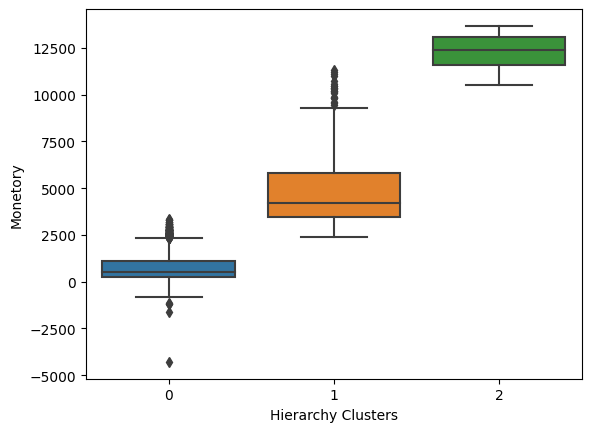

In [75]:
sns.boxplot(x="Hierarchy Clusters", y="Monetory", data=rfm)

<Axes: xlabel='Hierarchy Clusters', ylabel='Frequency'>

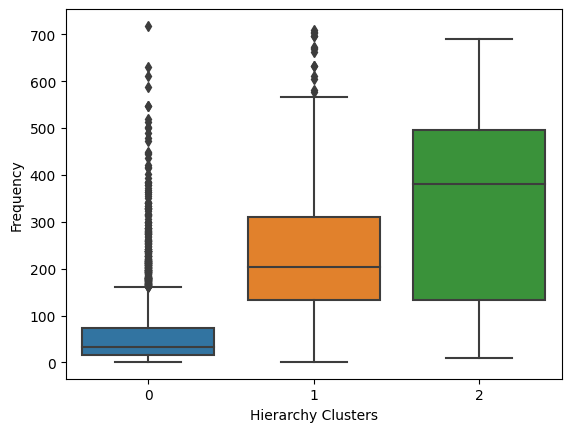

In [76]:
sns.boxplot(x="Hierarchy Clusters", y="Frequency", data=rfm)

<Axes: xlabel='Hierarchy Clusters', ylabel='Recency'>

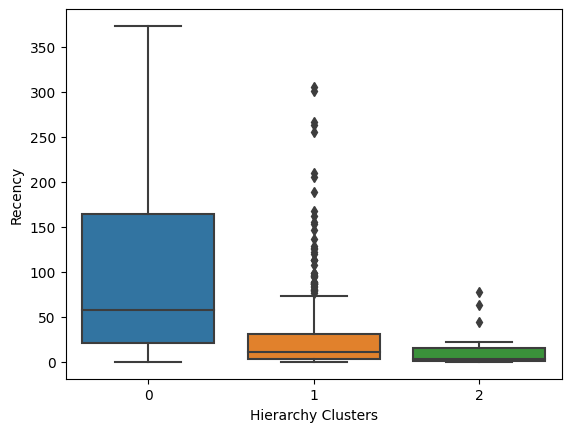

In [77]:
sns.boxplot(x="Hierarchy Clusters", y="Recency", data=rfm)

In [ ]:
k